#DUYGU TANIMA - KAGGLE VERİSETİ
https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data

---

[<img align="left" width="100" height="100" src="https://images.cdn2.stockunlimited.net/clipart/letter-a_1995332.jpg">](https://www.ayyucekizrak.com/)
[<img align="right" width="200" height="50"  src="https://raw.githubusercontent.com/deeplearningturkiye/pratik-derin-ogrenme-uygulamalari/944a247d404741ba37b9ef74de0716acff6fd4f9/images/dltr_logo.png">](https://deeplearningturkiye.com/)

Drive Hesap Doğrulama

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 18408 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Selecting previously unselected package dirmngr.
Preparing to unpack .../04-dirmngr_2.1.15-1ubuntu8.1_amd64.deb ...
Unpacking dirmngr (2.1.15-1ubuntu8.1) ...
Selecting previously unselected package distro-info-data.
Preparing to unpack .

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
!ls drive/DLTR_COLAB/DuyguTanima

data			      DLTR_DuyguTanima_Demo2.ipynb  images
DLTR_DuyguTanima_Demo1.ipynb  DLTR_DuyguTanima_Demo3.ipynb  utils


**UYGULAMA BAŞLANGICI**

In [0]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import keras
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


Bize verilen veriseti 35887 satır ve 3 kolondan oluşuyor

In [0]:
root = 'drive/DLTR_COLAB/DuyguTanima/'

data = pd.read_csv(root + "data/fer2013/fer2013.csv")
data.shape 

(35887, 3)

In [0]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [0]:
data["Usage"].value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

Usage kolonunda verisetindeki örnekler kaç gruba ayrılmış. Kaggle da genelde bu şekilde submit sonrası asıl test edilmesi için verisetinden bir kısmını "PrivateTest" olarak ayırırlar.

**EĞİTİM DATASI - ÖN İŞLEME**

In [0]:
np.unique(data["Usage"].values.ravel()) 

print('Eğitim verisetindeki örnek sayısı: %d'%(len(data[data.Usage == "Training"])))

Eğitim verisetindeki örnek sayısı: 28709


In [0]:
train_data = data[data.Usage == "Training"] #sadece eğitim örneklerini train_data değişkenine aldık

In [0]:
#eğitim örneklerinin piksel değerleri bize tablo halinde yan yana verildiği için boşluklardan parse ederek liste olarak değişkene aldık
train_pixels = train_data.pixels.str.split(" ").tolist() 

train_pixels = pd.DataFrame(train_pixels, dtype=int)
train_images = train_pixels.values
train_images = train_images.astype(np.float)

print(train_images)

print(train_images.shape)

[[ 70.  80.  82. ... 106. 109.  82.]
 [151. 150. 147. ... 193. 183. 184.]
 [231. 212. 156. ...  88. 110. 152.]
 ...
 [ 74.  81.  87. ... 188. 187. 187.]
 [222. 227. 203. ... 136. 136. 134.]
 [195. 199. 205. ...   6.  15.  38.]]
(28709, 2304)


In [0]:
#Resmi 48x48 px şeklinde göstermek için bir fonksiyon tanımlayalım
def show(img):
    show_image = img.reshape(48,48)
    
    plt.axis('off')
    plt.imshow(show_image, cmap='gray')

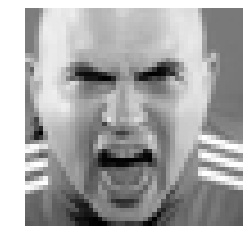

In [0]:
#bir eğitim örneği gösterelim
show(train_images[22])

In [0]:
train_labels_flat = train_data["emotion"].values.ravel()
train_labels_count = np.unique(train_labels_flat).shape[0]
print('Farklı yüz ifadelerinin sayısı: %d'%train_labels_count)

Farklı yüz ifadelerinin sayısı: 7


In [0]:
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

In [0]:
y_train = dense_to_one_hot(train_labels_flat, train_labels_count)
y_train = y_train.astype(np.uint8)

print(y_train.shape)

(28709, 7)


TEST DATASI - ÖN İŞLEME

In [0]:
np.unique(data["Usage"].values.ravel()) 

print('Test verisetindeki örnek sayısı: %d'%(len(data[data.Usage == "PublicTest"])))

Test verisetindeki örnek sayısı: 3589


In [0]:
test_data = data[data.Usage == "PublicTest"] 
test_pixels = test_data.pixels.str.split(" ").tolist() 

test_pixels = pd.DataFrame(test_pixels, dtype=int)
test_images = test_pixels.values
test_images = test_images.astype(np.float)

print(test_images.shape)


(3589, 2304)


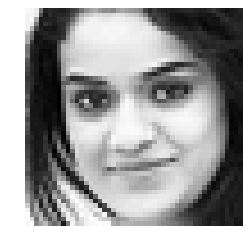

In [0]:
#bir test örneği gösterelim
show(test_images[5])

In [0]:
test_labels_flat = test_data["emotion"].values.ravel()
test_labels_count = np.unique(test_labels_flat).shape[0]

y_test = dense_to_one_hot(test_labels_flat, test_labels_count)
y_test = y_test.astype(np.uint8)


print(y_test.shape)

(3589, 7)


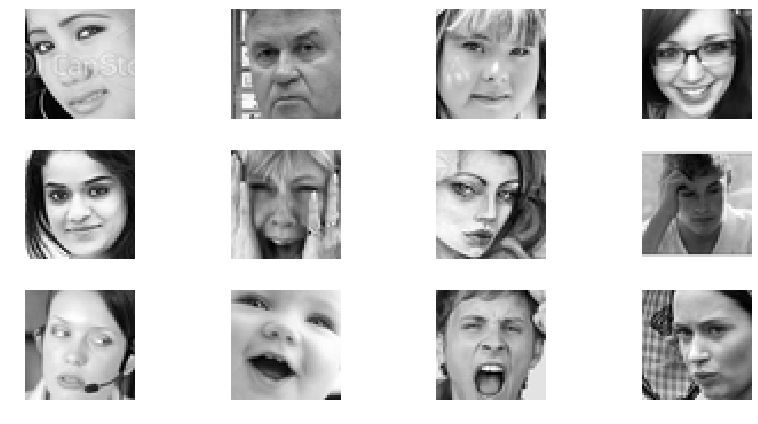

In [0]:
#test verisetinden örneklerden bir kaçını toplu halde görelim

plt.figure(0, figsize=(12,6))
for i in range(1, 13):
    plt.subplot(3,4,i)
    plt.axis('off')
    
    image = test_images[i].reshape(48,48)
    plt.imshow(image, cmap="gray")

plt.tight_layout()
plt.show()

Derin Öğrenme Modeli

In [0]:
model = Sequential()

model.add(Conv2D(64, 3, data_format="channels_last", kernel_initializer="he_normal", input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(64, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.6))

model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.6))

model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.6))

model.add(Dense(7))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 44, 44, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 44, 44, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 64)        0         
__________

In [0]:
x_train = train_images.reshape(-1, 48, 48, 1)
x_test = test_images.reshape(-1, 48, 48, 1)

print("Train:", x_train.shape)
print("Test:", x_test.shape)

Train: (28709, 48, 48, 1)
Test: (3589, 48, 48, 1)


In [0]:
print("Train:", y_train.shape)
print("Test:", y_test.shape)

Train: (28709, 7)
Test: (3589, 7)


In [0]:
# en başarılı ağırlıkları kaydet
checkpointer = ModelCheckpoint(filepath=root + 'data/face_model.h5', verbose=1, save_best_only=True)

epochs = 10
batchSize = 100 

# modeli çalıştır
hist = model.fit(x_train, y_train, 
                 epochs=epochs,
                 shuffle=True,
                 batch_size=batchSize, 
                 validation_data=(x_test, y_test),
                 callbacks=[checkpointer], verbose=2)

# save model to json
model_json = model.to_json()
with open(root + "data/face_model.json", "w") as json_file:
    json_file.write(model_json)

Train on 28709 samples, validate on 3589 samples
Epoch 1/10
 - 26s - loss: 1.3715 - acc: 0.4743 - val_loss: 1.3014 - val_acc: 0.4898

Epoch 00001: val_loss improved from inf to 1.30136, saving model to drive/DLTR_COLAB/DuyguTanima/data/face_model.h5
Epoch 2/10
 - 26s - loss: 1.3370 - acc: 0.4864 - val_loss: 1.2870 - val_acc: 0.5093

Epoch 00002: val_loss improved from 1.30136 to 1.28702, saving model to drive/DLTR_COLAB/DuyguTanima/data/face_model.h5
Epoch 3/10
 - 26s - loss: 1.3140 - acc: 0.4961 - val_loss: 1.2303 - val_acc: 0.5288

Epoch 00003: val_loss improved from 1.28702 to 1.23030, saving model to drive/DLTR_COLAB/DuyguTanima/data/face_model.h5
Epoch 4/10
 - 26s - loss: 1.2881 - acc: 0.5058 - val_loss: 1.2350 - val_acc: 0.5344

Epoch 00004: val_loss did not improve from 1.23030
Epoch 5/10
 - 26s - loss: 1.2691 - acc: 0.5136 - val_loss: 1.2050 - val_acc: 0.5358

Epoch 00005: val_loss improved from 1.23030 to 1.20496, saving model to drive/DLTR_COLAB/DuyguTanima/data/face_model.h5

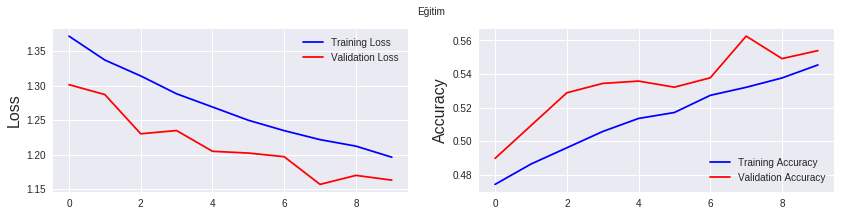

In [0]:
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.suptitle('Eğitim', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], color='b', label='Training Loss')
plt.plot(hist.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['acc'], color='b', label='Training Accuracy')
plt.plot(hist.history['val_acc'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

Kaggle submit edecek gibi **PrivateTest** örnekleri ile test edelim

In [0]:
test = data[["emotion", "pixels"]][data["Usage"] == "PrivateTest"]
test["pixels"] = test["pixels"].apply(lambda im: np.fromstring(im, sep=' '))
test.head()

,emotion,pixels
32298,0,"[170.0, 118.0, 101.0, 88.0, 88.0, 75.0, 78.0, ..."
32299,5,"[7.0, 5.0, 8.0, 6.0, 7.0, 3.0, 2.0, 6.0, 5.0, ..."
32300,6,"[232.0, 240.0, 241.0, 239.0, 237.0, 235.0, 246..."
32301,4,"[200.0, 197.0, 149.0, 139.0, 156.0, 89.0, 111...."
32302,2,"[40.0, 28.0, 33.0, 56.0, 45.0, 33.0, 31.0, 78...."


In [0]:
x_test_private = np.vstack(test["pixels"].values)
y_test_private = np.array(test["emotion"])

In [0]:
x_test_private = x_test_private.reshape(-1, 48, 48, 1)
y_test_private = np_utils.to_categorical(y_test_private)
x_test_private.shape, y_test_private.shape

((3589, 48, 48, 1), (3589, 7))

In [0]:
score = model.evaluate(x_test_private, y_test_private, verbose=0)
print("PrivateTest üzerinde doğruluk başarımı:", score)

PrivateTest üzerinde doğruluk başarımı: [1.159390372697209, 0.5564224017915304]


Kendi örneklerimiz ile test edelim

(48, 48, 1)

In [0]:
x_test_private = test_images[5].reshape(-1, 48, 48, 1)

In [0]:
import cv2

In [0]:
!ls 'drive/DLTR_COLAB/DuyguTanima/images'

bb1.jpg      lotr1.png	_predicted_image.jpg  test4.jpg  test.jpg
bb2.jpg      lotr2.jpg	test2.jpg	      test5.jpg
hababam.jpg  lotr3.jpg	test3.jpg	      test6.jpg


In [0]:
# en iyi ağırlıkları yükle
model.load_weights(root + 'data/face_model.h5')

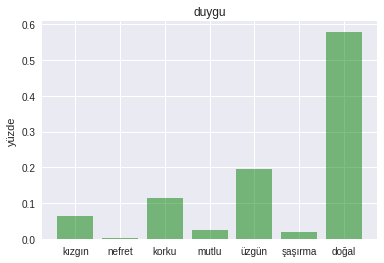

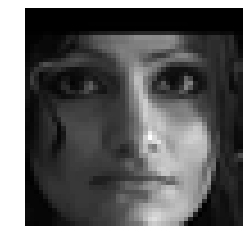

In [0]:
test_image=x_test_private[15]

custom = model.predict(test_image.reshape(-1, 48, 48, 1))


#1
objects = ('kızgın', 'nefret', 'korku', 'mutlu', 'üzgün', 'şaşırma', 'doğal')
y_pos = np.arange(len(objects))
    
plt.bar(y_pos, custom[0], align='center', alpha=0.5, color='g')
plt.xticks(y_pos, objects)
plt.ylabel('yüzde')
plt.title('duygu')
plt.show()

#2
x = np.array(x, 'float32')
x = x.reshape([48, 48]);
plt.axis('off')
plt.gray()
plt.imshow(test_image.reshape(48,48))

plt.show()
#------------------------------

In [0]:
custom

array([[0.06448399, 0.00337856, 0.11355548, 0.02580728, 0.19515865,
        0.01834167, 0.5792744 ]], dtype=float32)

In [0]:
ind = 0.1+0.6*np.arange(len(objects))
ind

array([0.1, 0.7, 1.3, 1.9, 2.5, 3.1, 3.7])

In [0]:
ind = 0.1+0.6*np.arange(len(objects)) 

width = 0.4   
color_list = ['red','orangered','darkorange','limegreen','darkgreen','royalblue','navy']
for i in range(len(objects)):
    plt.bar(ind[i], custom[i], width, color=color_list[i])
plt.title("Classification results ",fontsize=20)
plt.xlabel(" Expression Category ",fontsize=16)
plt.ylabel(" Classification Score ",fontsize=16)
plt.xticks(ind, objects, rotation=45, fontsize=14)